In [1]:
# Imports
import numpy as np
import altair as alt
import pydot
from IPython.display import display, SVG, clear_output, HTML
import matplotlib.pyplot as plt

from pydrake.all import *
from pydrake.examples.manipulation_station import ManipulationStation

from manipulation import running_as_notebook
from manipulation.meshcat_cpp_utils import (
    StartMeshcat, MeshcatJointSlidersThatPublish)
from manipulation.scenarios import AddMultibodyTriad, SetColor

In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

In [3]:
# Adding a table

builder = DiagramBuilder()

# urdf_path = './diva_teleop_boxy.urdf'
# urdf_path = './urdfs/sample_designs/divar3v7303.urdf'
urdf_path = './divar3v-reference.urdf'
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
model = Parser(plant, scene_graph).AddModelFromFile(urdf_path, 'diva_robot')


# Transform for the table location
X_R = RigidTransform(RotationMatrix.MakeYRotation(-np.pi/2), np.array([-0.1, 0.5, 1]))
# For shoulder re-orientation use below
# X_R = RigidTransform(RotationMatrix(RollPitchYaw([0.8, -0.8, 0])), np.array([-0.1, 0.5, 1]))
Parser(plant, scene_graph).AddModelFromFile('./urdfs/table/extra_heavy_duty_table_modified.sdf','table')

plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(model)[0]).body_frame(), X_R)
# plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(table)[0]).body_frame(), X_T)
plant.Finalize()

# Delete any previous models
meshcat.Delete()
meshcat.DeleteAddedControls()

visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()
context = diagram.CreateDefaultContext()
plant.SetPositions(plant.GetMyContextFromRoot(context),model,
                      [0.21, -1.03, 1.28, -1.1, 2.8, 1.5, 0])
# To actually see the context, publish diagram
diagram.Publish(context)

In [4]:
plant_context = plant.GetMyMutableContextFromRoot(context)
# Compute mass matrix
Mmat = plant.CalcMassMatrix(plant_context)

In [10]:
# Extracting the diagonal parts of the inertia matrix
Mmat.diagonal()
# Rotor inerta of T-motors AK60-6 is not found in specifications
# So using the formula from the paper
rotor_inertia = 7.19e-4*(315/1000)**1.67
gear_ratio = 6
reflected_inertia = gear_ratio**2*rotor_inertia
# print(reflected_inertia, Mmat.diagonal().max(), Mmat.diagonal().min())
print('Rotor inertia: ', rotor_inertia)
print('Minmax inertia from mass matrix: ', Mmat.diagonal().max(), Mmat.diagonal().min())
# Since the reflected inertia is still smaller compared to the 
# moving inertia, it is neglected until I undertsand how to incorporate 
# it in the model
# Reference for incorporating rotor inertia in pydrake: https://github.com/RobotLocomotion/drake/issues/12335
# Not yet implemented in python\

# Accessing the joint actuator to add rotor_inertia and gear ratio
motor = plant.GetJointActuatorByName('motor1')
motor.name()
motor.effort_limit();
# Not implemented yet
# motor.rotor_inertia

Rotor inertia:  0.0001044497765458742
Minmax inertia from mass matrix:  0.3236230003129791 0.0007021024339824005


In [17]:
# Check if the regression from the paper is valid with T-motors
m_m = 315/1000
# Max motor torque
tau_max = 5.48*m_m**0.97
# After gear reduction
print(gear_ratio*tau_max)
# The actual tau_max is 9
# Since its a regression, this is close enough

10.722425712925261


In [11]:
builder = DiagramBuilder()
urdf_path = './divar3v-reference.urdf'
# urdf_path = './diva_teleop_boxy.urdf'
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
model = Parser(plant, scene_graph).AddModelFromFile(urdf_path, 'diva_robot')
# Transform for the robot location
X_R = RigidTransform(RotationMatrix.MakeYRotation(-np.pi/2), np.array([-0.1, 0.5, 1]))
plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(model)[0]).body_frame(), X_R)
# Spawn table
table = Parser(plant, scene_graph).AddModelFromFile('./urdfs/table/extra_heavy_duty_table_modified.sdf','table')
# Spawn spherical work piece
sphere = Parser(plant, scene_graph).AddModelFromFile('./urdfs/helper/sphere.urdf','sphere')
# Place the sphere at the center of the table
# Length, width and height and thickness of the table
# 1.39, 0.762, 0.736, 0.057
# Sphere radius -- Can be made a design variable
# 0.15
# We can sample end-points on the surface of the sphere
X_R = RigidTransform(RotationMatrix(RollPitchYaw([0, 0, 0])), np.array([0, 0, 0.736]))
plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(sphere)[0]).body_frame(), X_R)

plant.Finalize()


# Draw the frames
for body_name in ["base_link", "eef"]:
    AddMultibodyTriad(plant.GetFrameByName(body_name, model), scene_graph)

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

# Adds an approximation of the iiwa controller.
# TODO(russt): replace this with the joint impedance controller.
Kp = np.full(7, 5.5)
# Ki = 2 * np.sqrt(Kp)
Ki = np.full(7, 0)
# Kd = np.full(7, 1)
Kd = 2 * np.sqrt(Kp)
iiwa_controller = builder.AddSystem(InverseDynamicsController(plant, Kp, Ki, Kd, False))
iiwa_controller.set_name("iiwa_controller");
builder.Connect(plant.get_state_output_port(model),
                iiwa_controller.get_input_port_estimated_state())
builder.Connect(iiwa_controller.get_output_port_control(),
                plant.get_actuation_input_port())
# Connecting a data logger
logger1 = LogVectorOutput(iiwa_controller.get_output_port_control(), builder)
logger2 = LogVectorOutput(plant.get_state_output_port(model), builder)

diagram = builder.Build()

In [18]:
# SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())

In [13]:
# diagram.set_name("diagram")
# HTML('<script src="https://unpkg.com/gojs/release/go.js"></script>' + GenerateHtml(diagram))

In [19]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
q0 = plant.GetPositions(plant_context)
gripper_frame = plant.GetBodyByName("eef").body_frame()
# Initial position and velocity
# cart0 = np.array([np.random.uniform(-0.17, -0.695), np.random.uniform(-0.381, 0.381), np.random.uniform(0.74, 0.80)])
# cartd = np.array([np.random.uniform(-0.17, 0), np.random.uniform(-0.17, 0.17), np.random.uniform(0.74, 0.90)])
cart0 = np.array([-0.35, 0.15, 0.8])
cartd = np.array([0,0,0.8])
# Compute IK
ik = InverseKinematics(plant, plant_context)
ik.AddPositionConstraint(
            gripper_frame, [0, 0, 0], plant.world_frame(), 
            cart0, cart0)
prog = ik.get_mutable_prog()
q = ik.q()
prog.AddQuadraticErrorCost(np.identity(len(q)), q0, q)
prog.SetInitialGuess(q, q0)
result = Solve(ik.prog())
q0 = result.GetSolution(ik.q())

# Document mapping bottom-up mapping from link 
# lengths to the workspace

ik = InverseKinematics(plant, plant_context)
ik.AddPositionConstraint(
            gripper_frame, [0, 0, 0], plant.world_frame(), 
            cartd, cartd)
prog = ik.get_mutable_prog()
q = ik.q()
prog.AddQuadraticErrorCost(np.identity(len(q)), q0, q)
prog.SetInitialGuess(q, q0)
result = Solve(ik.prog())
qd = result.GetSolution(ik.q())
print(qd)

# q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
# # Setting the desired position
# qd = np.array([0.21, -1.03, 1.28, -1.1, 2.8, 1.5, 0])
# x0 = np.hstack((q0, 0*q0))
xd = np.hstack((qd, 0*qd))
plant.SetPositions(plant_context, q0)
iiwa_controller.GetInputPort('desired_state').FixValue(
    iiwa_controller.GetMyMutableContextFromRoot(context), xd)
# print(context)
diagram.Publish(context)

[ 0.30424047  0.48715449  0.47032551 -0.99735637  0.05934939 -0.36167854
  0.09665982]


In [20]:
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(-1.0);
# simulator.set_target_realtime_rate(1.0);
# simulator.AdvanceTo(5.0 if running_as_notebook else 0.1);
logger1.FindMutableLog(context).Clear()
simulator.AdvanceTo(5.0);

In [21]:
# Now we want to get the simulation data, i.e., 
# the torque applied, final time and the 
log1 = logger1.FindLog(context)
log2 = logger2.FindLog(context)

In [22]:
# Final control input
log1.data()[:, -1]

array([ 7.19444348, -1.38272278,  0.52419946,  1.38202471,  0.02150888,
        0.05186687,  0.04254594])

In [53]:
# Extracting the angular velocity
vel = []
for i in range(log2.data().shape[1]):
    vel.append(log2.data()[:,i][7:])
vel = np.array(vel).transpose()

In [73]:
# max velocity in radians/sec
traj_max_vel = np.max(vel*gear_ratio)
print(traj_max_vel)
# Max velocity of the T-motor AK60
motor_max_vel = 400*2*np.pi/60.0
print(max_vel)
# We are well within the angular velocity peak

38.342396111348336
41.88790204786391


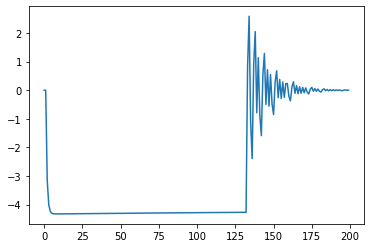

In [80]:
plt.plot(vel[6, :200])

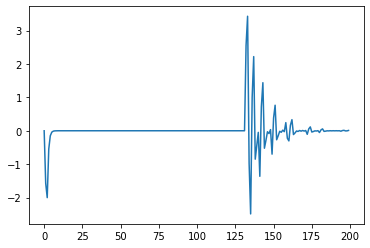

In [79]:
plt.plot(np.gradient(vel[6, :200]))

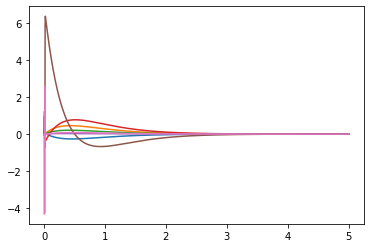

In [57]:
# Angular velocity of the robot
plt.plot(log1.sample_times(), vel[0, :-1], log1.sample_times(), vel[1, :-1],\
        log1.sample_times(), vel[2, :-1], log1.sample_times(), vel[3, :-1], \
        log1.sample_times(), vel[4, :-1], log1.sample_times(), vel[5, :-1], \
        log1.sample_times(), vel[6, :-1])

In [23]:
# Final state of the robot
log2.data()[:, -1]

array([ 3.04274473e-01,  4.87098907e-01,  4.70300903e-01, -9.97468241e-01,
        5.93467462e-02, -3.61440997e-01,  9.66489178e-02, -7.33803773e-05,
        1.20019666e-04,  5.31381339e-05,  2.41242066e-04,  5.72373262e-06,
       -5.08546380e-04,  2.35174706e-05])

In [24]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

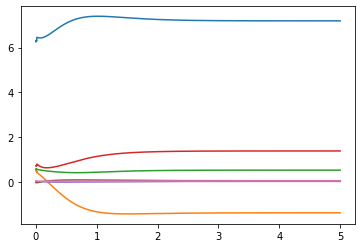

In [25]:
plt.plot(log1.sample_times(), log1.data()[0, :], log1.sample_times(), log1.data()[1, :],\
        log1.sample_times(), log1.data()[2, :], log1.sample_times(), log1.data()[3, :], \
        log1.sample_times(), log1.data()[4, :], log1.sample_times(), log1.data()[5, :], \
        log1.sample_times(), log1.data()[6, :])

In [26]:
# Max torque required
# We can enforce max torque requirements at each joint in the URDF itself
np.max(log1.data())

7.4012326624716085

In [27]:
# Now we need to compute settling time
log2.data()[:, 0]

array([ 0.6097111 , -0.04402484,  0.22363931, -1.88203719,  0.01227733,
       -0.72208045,  0.05594299,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [28]:
# Use the same formula as before for the settling time
ts = 8/np.sqrt(Kp)[0]
print(ts)

3.4112114616897666


In [29]:
# We need to compute forces on the end-effector
G = plant.GetBodyByName("eef").body_frame()
W = plant.world_frame()
J_G = plant.CalcJacobianSpatialVelocity(plant_context, JacobianWrtVariable.kQDot, G, [0,0,0], W, W)
# We need forces in Z direction in general but at kind of force and moment can be 
# added as long as the system is statico
joint_torques = np.matmul(J_G.transpose(), np.array([0,0,-10,0,0,-5]))
print(joint_torques)
print(np.max(abs(joint_torques)))

[-2.50011063 -8.89355844 -3.29874243  1.62147403  6.14110439  3.25706887
 -4.54234846]
8.893558444633708


In [30]:
# For payload computation
# We need to compute forces on the end-effector
G = plant.GetBodyByName("eef").body_frame()
W = plant.world_frame()
plant.SetPositions(plant.GetMyContextFromRoot(context),model,
                      [0,-1.57,0,0,0,0,0])
diagram.Publish(context)

J_G = plant.CalcJacobianSpatialVelocity(plant_context, JacobianWrtVariable.kQDot, G, [0,0,0], W, W)
joint_torques = np.matmul(J_G.transpose(), np.array([0,10,0,0,0,0]))
print(joint_torques)
print(np.max(abs(joint_torques)))

[ 0.00000000e+00  0.00000000e+00 -6.99999943e-03  9.99999755e+00
 -6.99999943e-03  9.99999755e+00  0.00000000e+00]
9.9999975500001


In [ ]:
# Now all that is left is to integrate these
# bottom-up mappings with auto-generation of the URDF
# and solution space computation

In [136]:
# Motor angular velocity
omega = []
for i in range(log2.data().shape[1]):
    omega.append(log2.data()[:,i][7:])
omega_m = np.array(omega).transpose()*gear_ratio
# Motor torque
tau_m = log1.data()/gear_ratio

# Friction torque
tau_mu = 5.3e-3
b0 = 1.5e-5
# Motor constant matrix
km = 0.14
K = 1/np.sqrt(km)*np.identity(7)

# Total friction power loss
inst_friction_power = []
inst_joule_power = []

for i in range(len(log1.sample_times())):
    omega_inst = omega_m[:, i]
    tau_f = tau_mu*np.sign(omega_inst)+b0*omega_inst
    P_f = np.dot(tau_f, omega_inst)
    inst_friction_power.append(P_f)
    tau_t = tau_f+tau_m[:, i]
    P_t = np.dot(K.dot(tau_t), tau_t)
    inst_joule_power.append(P_t)
# Normalising to step size, since its an integration
# If the step size is constant, this can be ignored
print('friction losses: ', np.sum(inst_friction_power)*1e-4)
# Losses due to joule effecto at motor windings
print('joule losses: ', np.sum(inst_joule_power)*1e-4)

friction losses:  0.13502463218521363
joule losses:  20.461600033367795


max power used:  4.291270288949051 W


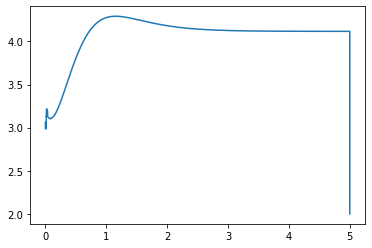

In [137]:
# The joule losses feel very high, is this common or is 
plt.plot(log1.sample_times(), inst_joule_power)
print("max power used: ", np.max(inst_joule_power), "W")

In [134]:
log1.sample_times()

array([0.0000e+00, 1.0000e-04, 2.0000e-04, ..., 4.9999e+00, 5.0000e+00,
       5.0000e+00])

In [ ]:
# Now make DIVAR3V compatible with xray-tool v0.0.3a and add these QoI
# Add sphere for joint
# Add dependency of motor mass on max-torque

In [3]:
38.342396111348336*60/(2*np.pi)

366.14291226651324